# Effective DOF test

## Import package

In [1]:
import numpy as np
import netCDF4 as nc

from scipy.stats import t
from matplotlib.colors import TwoSlopeNorm
from matplotlib import pyplot as plt

## Load data

In [2]:
# Load MPAS data
## dimension
import time


dims: dict[str, np.ndarray] = dict()

temp: dict[str, np.ndarray] = dict()


## variables
with nc.Dataset("/work/b11209013/2024_Research/MPAS/merged_data/CNTL/theta.nc", "r") as f:
    for key in f.dimensions.items():
        dims[key[0]] = f.variables[key[0]][:]

    lat_lim: list[int] = np.where((dims["lat"][:] >= -5) & (dims["lat"][:] <= 5))[0]

    temp["CNTL"] = (f.variables["theta"][:, :, lat_lim, :].mean(axis=2) * (1000/dims["lev"])[None, :, None]**(-0.286)) - 273.15

with nc.Dataset("/work/b11209013/2024_Research/MPAS/merged_data/NCRF/theta.nc", "r") as f:
    temp["NCRF"] = (f.variables["theta"][:, :, lat_lim, :].mean(axis=2) * (1000/dims["lev"])[None, :, None]**(-0.286)) - 273.15

# load events
lon_ref: dict[str, np.ndarray] = dict()
time_ref: dict[str, np.ndarray] = dict()

for key in temp.keys():
    lon_ref[key], time_ref[key] = np.load(
        f"/home/b11209013/2024_Research/MPAS/Composite/Q1_event_sel/Q1_sel/{key}.npy"
    )


### Acquiring anomaly

In [3]:
for key in temp.keys():
    temp[key] -= temp[key].mean(axis=(0, 2))[None, :, None]

## Event selection

### Time interval setting

In [4]:
time_itv: dict[str, np.ndarray] = dict()

for key in temp.keys():
    time_itv[key] = np.array([
        np.linspace(time_ref[key][i]-12, time_ref[key][i]+12, 25)
        for i in range(time_ref[key].shape[0])
    ])


### Event selection

In [5]:
temp_sel: dict[str, np.ndarray] = dict()

for key in temp.keys():
    temp_sel[key] = np.array([
        temp[key][time_itv[key][i].astype(int), :, lon_ref[key][i].astype(int)]
        for i in range(time_ref[key].shape[0])
    ])
    
print(temp_sel["CNTL"].shape)

(26, 25, 38)


## T-test

In [9]:
mean: dict[str, np.ndarray] = dict(
    CNTL = temp_sel["CNTL"].mean(axis=0),
    NCRF = temp_sel["NCRF"].mean(axis=0)
)

std_err: dict[str, np.ndarray] = dict(
    CNTL = temp_sel["CNTL"].var(axis=0)/temp_sel["CNTL"].shape[0],
    NCRF = temp_sel["NCRF"].var(axis=0)/temp_sel["NCRF"].shape[0]
)

t_score = (mean["CNTL"] - mean["NCRF"]) / np.sqrt(std_err["NCRF"] + std_err["CNTL"])

dof = (std_err["NCRF"] + std_err["CNTL"])**2 / (std_err["NCRF"]**2/(temp_sel["NCRF"].shape[0]-1) + std_err["CNTL"]**2/(temp_sel["CNTL"].shape[0]-1))

critical_value = t.ppf(0.975, dof)

significant_diff = np.where(np.abs(t_score) > critical_value, 1, np.nan)

## Plot

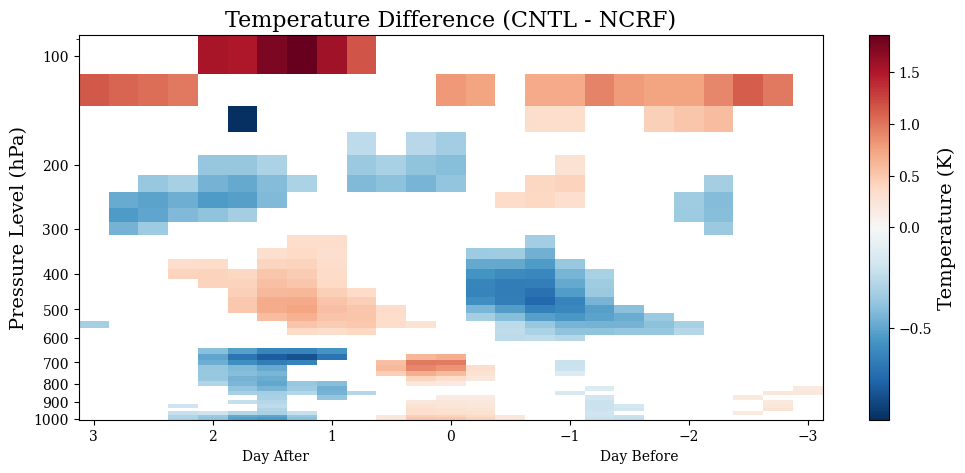

In [8]:
plt.rcParams.update({
    'font.size': 10,
    'figure.titlesize': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'font.family': 'serif',
})

plt.figure(figsize=(12, 5))
plt.pcolormesh(np.linspace(-3, 3, 25), dims["lev"], ((mean["CNTL"] - mean["NCRF"])*significant_diff).T, cmap="RdBu_r", norm=TwoSlopeNorm(vcenter=0))
plt.yscale("log")
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10, dtype=int))
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.ylabel("Pressure Level (hPa)")
plt.text(1.75, 1300, "Day After")
plt.text(-1.25, 1300, "Day Before")
plt.title("Temperature Difference (CNTL - NCRF)")
cb = plt.colorbar(label="Temperature (K)")
plt.savefig("raw_diff.png", dpi=300)